2025-10-26 08:48:53.056843: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761468533.539983      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761468533.658614      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading model from /kaggle/input/adni-dataset-model/keras/default/1/best_oasis_model (1).keras...


I0000 00:00:1761468554.784920      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761468554.785624      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model loaded successfully.
Loading labeled test data from /kaggle/input/mendeley-old-dataset-final/alzheimer mendeley/OriginalDataset...
Found 6400 files belonging to 4 classes.
Found 6400 images in 4 classes.
Making predictions on test set...


I0000 00:00:1761468564.802234      62 service.cc:148] XLA service 0x787478004570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761468564.803805      62 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761468564.803823      62 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761468564.980106      62 cuda_dnn.cc:529] Loaded cuDNN version 90300


 12/200 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

I0000 00:00:1761468567.156578      62 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step

--- Classification Report ---
                    precision    recall  f1-score   support

     Mild Dementia       0.94      0.99      0.97       896
 Moderate Dementia       0.90      1.00      0.95        64
      Non Demented       1.00      0.97      0.99      3200
Very mild Dementia       0.97      0.98      0.98      2240

          accuracy                           0.98      6400
         macro avg       0.95      0.99      0.97      6400
      weighted avg       0.98      0.98      0.98      6400


--- Confusion Matrix ---
[[ 891    0    1    4]
 [   0   64    0    0]
 [  29    0 3117   54]
 [  25    7    7 2201]]
Generating confusion matrix plot...
Confusion matrix plot saved as: confusion_matrix.png


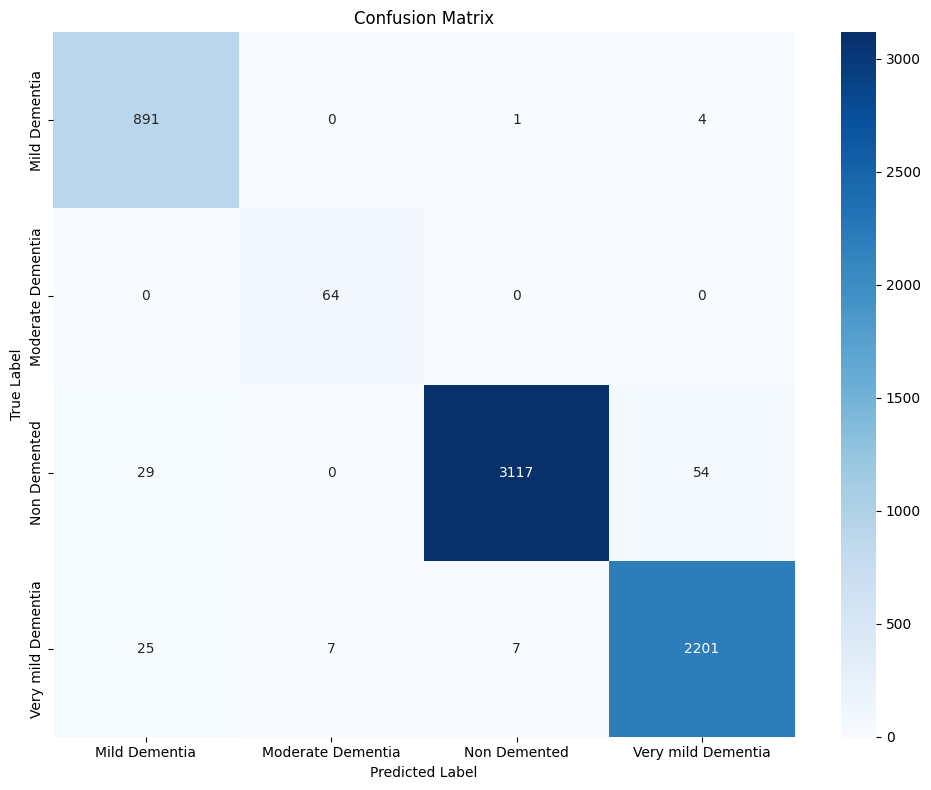

In [1]:
import tensorflow as tf
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# --- 1. SET YOUR PARAMETERS ---

# !! REPLACE THIS !!
# Path to the saved .keras model file
MODEL_FILE_PATH = '/kaggle/input/adni-dataset-model/keras/default/1/best_oasis_model (1).keras'

# !! REPLACE THIS !!
# Path to the PARENT folder of your *labeled* test data.
# This folder should contain the subfolders for each class.
TEST_DATA_DIR = '/kaggle/input/mendeley-old-dataset-final/alzheimer mendeley/OriginalDataset'


# --- Parameters from your notebook (Do not change) ---
IMG_HEIGHT = 180
IMG_WIDTH = 180
BATCH_SIZE = 32
CLASS_NAMES = [
    'Mild Dementia', 
    'Moderate Dementia', 
    'Non Demented', 
    'Very mild Dementia'
]

# --- 2. LOAD THE SAVED MODEL ---
print(f"Loading model from {MODEL_FILE_PATH}...")
try:
    model = tf.keras.models.load_model(MODEL_FILE_PATH)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# --- 3. LOAD THE LABELED TEST DATA ---
print(f"Loading labeled test data from {TEST_DATA_DIR}...")

try:
    # Load the dataset, this time with 'labels="inferred"' (the default)
    # Set shuffle=False to keep data and labels in order
    test_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=TEST_DATA_DIR,
        labels='inferred',
        label_mode='int',  # We want integer labels (0, 1, 2, 3)
        class_names=CLASS_NAMES, # Ensure order is correct
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        color_mode='rgb',  # Must be 'rgb' as required by the model
        batch_size=BATCH_SIZE,
        shuffle=False  # CRITICAL: Do not shuffle
    )
    
    print(f"Found {len(test_dataset.file_paths)} images in {len(test_dataset.class_names)} classes.")

    # --- 4. APPLY PREPROCESSING ---
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    
    # We map the dataset to apply the normalization
    # and also separate images (x) from labels (y)
    test_dataset_scaled = test_dataset.map(lambda x, y: (normalization_layer(x), y))

except Exception as e:
    print(f"Error loading images: {e}")
    print("Please check your TEST_DATA_DIR path and folder structure.")
    exit()


# --- 5. MAKE PREDICTIONS & GET TRUE LABELS ---

print("Making predictions on test set...")
# Predict on the entire scaled dataset
predictions = model.predict(test_dataset_scaled)

# Get the class with the highest probability (e.g., 0, 1, 2, or 3)
y_pred = np.argmax(predictions, axis=1)

# Get the true labels (y_true) from the dataset
# This concatenates the labels from all batches
y_true = np.concatenate([y for x, y in test_dataset], axis=0)


# --- 6. GENERATE CONFUSION MATRIX & REPORT ---

print("\n--- Classification Report ---")
# Print the classification report
report = classification_report(y_true, y_pred, target_names=CLASS_NAMES)
print(report)


print("\n--- Confusion Matrix ---")
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)


# --- 7. PLOT AND SAVE THE CONFUSION MATRIX ---
print("Generating confusion matrix plot...")
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

# Save the figure
plot_filename = 'confusion_matrix.png'
plt.savefig(plot_filename)
print(f"Confusion matrix plot saved as: {plot_filename}")

Loading model from /kaggle/input/adni-dataset-model/keras/default/1/best_oasis_model (1).keras...
Model loaded successfully.
Loading labeled test data from /kaggle/input/mendeley-old-dataset-final/alzheimer mendeley/OriginalDataset...
Found 6400 files belonging to 4 classes.
Found 6400 images in 4 classes.
Making predictions on test set...
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step

--- Classification Report ---
                    precision    recall  f1-score   support

     Mild Dementia       0.94      0.99      0.97       896
 Moderate Dementia       0.90      1.00      0.95        64
      Non Demented       1.00      0.97      0.99      3200
Very mild Dementia       0.97      0.98      0.98      2240

          accuracy                           0.98      6400
         macro avg       0.95      0.99      0.97      6400
      weighted avg       0.98      0.98      0.98      6400


--- Standard Confusion Matrix (Counts) ---
[[ 891    0    1    4]
 [   0   64    0    0]
 [  29    0 

/tmp/ipykernel_19/179977289.py:134: RuntimeWarning: invalid value encountered in divide
  cm_avg_confidence = np.nan_to_num(cm_sum_confidence / cm_counts_again)


Average confidence matrix plot saved as: confusion_matrix_avg_confidence.png


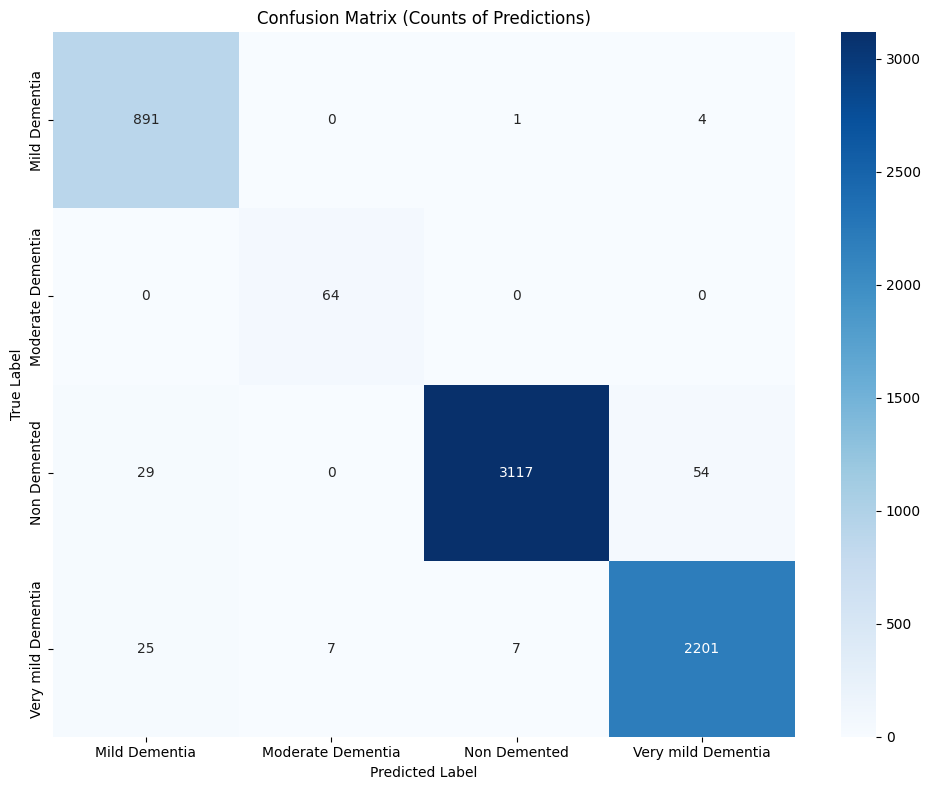

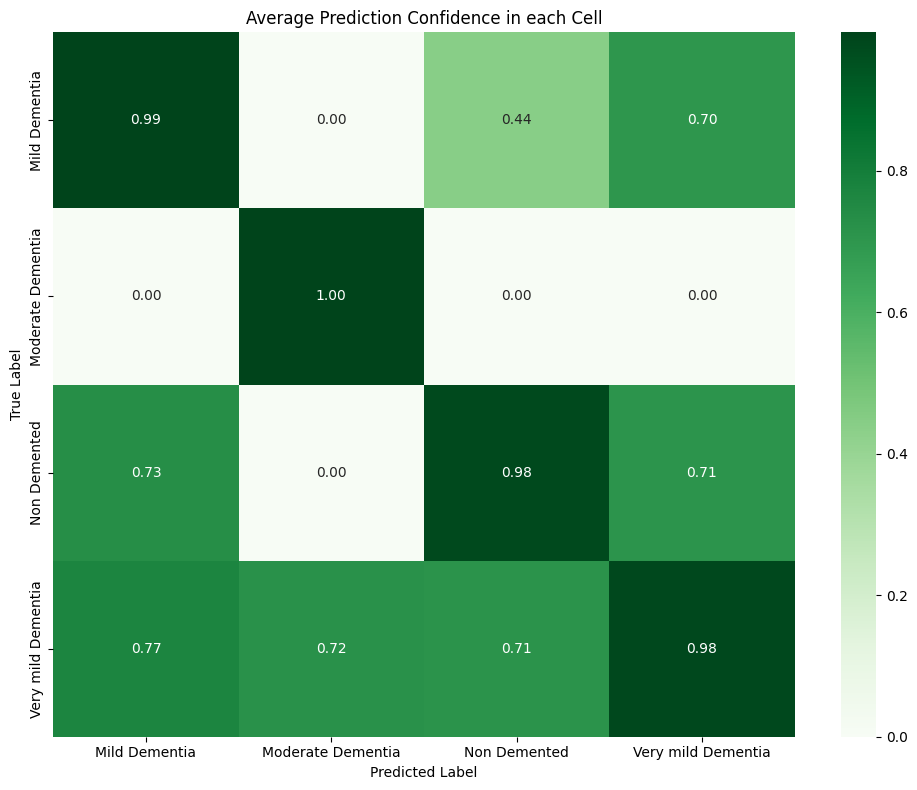

In [2]:
import tensorflow as tf
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# --- 1. SET YOUR PARAMETERS ---

# !! REPLACE THIS !!
# Path to the saved .keras model file
MODEL_FILE_PATH = '/kaggle/input/adni-dataset-model/keras/default/1/best_oasis_model (1).keras'

# !! REPLACE THIS !!
# Path to the PARENT folder of your *labeled* test data.
# This folder should contain the subfolders for each class.
TEST_DATA_DIR = '/kaggle/input/mendeley-old-dataset-final/alzheimer mendeley/OriginalDataset'


# --- Parameters from your notebook (Do not change) ---
IMG_HEIGHT = 180
IMG_WIDTH = 180
BATCH_SIZE = 32
CLASS_NAMES = [
    'Mild Dementia', 
    'Moderate Dementia', 
    'Non Demented', 
    'Very mild Dementia'
]

# --- 2. LOAD THE SAVED MODEL ---
print(f"Loading model from {MODEL_FILE_PATH}...")
try:
    model = tf.keras.models.load_model(MODEL_FILE_PATH)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# --- 3. LOAD THE LABELED TEST DATA ---
print(f"Loading labeled test data from {TEST_DATA_DIR}...")
try:
    test_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=TEST_DATA_DIR,
        labels='inferred',
        label_mode='int',  
        class_names=CLASS_NAMES, 
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        color_mode='rgb',  # Must be 'rgb' as required by the model
        batch_size=BATCH_SIZE,
        shuffle=False  # CRITICAL: Do not shuffle
    )
    
    print(f"Found {len(test_dataset.file_paths)} images in {len(test_dataset.class_names)} classes.")

    # --- 4. APPLY PREPROCESSING ---
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    test_dataset_scaled = test_dataset.map(lambda x, y: (normalization_layer(x), y))

except Exception as e:
    print(f"Error loading images: {e}")
    print("Please check your TEST_DATA_DIR path and folder structure.")
    exit()


# --- 5. MAKE PREDICTIONS & GET TRUE LABELS ---

print("Making predictions on test set...")
# Predict on the entire scaled dataset
# 'predictions' = all probabilities, e.g., [[0.1, 0.2, 0.7, 0.0], ...]
predictions = model.predict(test_dataset_scaled) 

# Get the class with the highest probability (e.g., 0, 1, 2, or 3)
y_pred = np.argmax(predictions, axis=1)

# Get the confidence score for the *predicted* class
# 'confidences' = the single highest score, e.g., [0.7, ...]
confidences = np.max(predictions, axis=1)

# Get the true labels (y_true) from the dataset
y_true = np.concatenate([y for x, y in test_dataset], axis=0)


# --- 6. GENERATE CONFUSION MATRIX & REPORT ---

print("\n--- Classification Report ---")
# Print the classification report
report = classification_report(y_true, y_pred, target_names=CLASS_NAMES)
print(report)


print("\n--- Standard Confusion Matrix (Counts) ---")
# Generate the standard confusion matrix (shows counts)
cm_counts = confusion_matrix(y_true, y_pred)
print(cm_counts)


# --- 7. PLOT AND SAVE THE STANDARD (COUNTS) MATRIX ---
print("Generating standard confusion matrix plot (with counts)...")
plt.figure(figsize=(10, 8))
sns.heatmap(cm_counts, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix (Counts of Predictions)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

# Save the figure
plot_filename = 'confusion_matrix_counts.png'
plt.savefig(plot_filename)
print(f"Standard confusion matrix plot saved as: {plot_filename}")


# --- 8. CALCULATE & PLOT AVERAGE CONFIDENCE MATRIX ---
print("\nCalculating average confidence for each matrix cell...")
num_classes = len(CLASS_NAMES)
cm_sum_confidence = np.zeros((num_classes, num_classes))
cm_counts_again = np.zeros((num_classes, num_classes))

# Loop over every prediction
for i in range(len(y_true)):
    true_label = y_true[i]
    pred_label = y_pred[i]
    confidence = confidences[i]
    
    # Add the confidence to the correct (true, pred) cell
    cm_sum_confidence[true_label, pred_label] += confidence
    # Increment the count for that cell
    cm_counts_again[true_label, pred_label] += 1

# Calculate average, handling division by zero
# np.nan_to_num replaces NaN (from 0/0) with 0.0
cm_avg_confidence = np.nan_to_num(cm_sum_confidence / cm_counts_again)


print("Generating average confidence matrix plot...")
plt.figure(figsize=(10, 8))
# Plot the average confidence, format as '.2f' (e.g., 0.95)
# Use a different color map (like 'Greens') to distinguish them
sns.heatmap(cm_avg_confidence, annot=True, fmt='.2f', cmap='Greens',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES)
plt.title('Average Prediction Confidence in each Cell')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

# Save the new figure
plot_filename_avg = 'confusion_matrix_avg_confidence.png'
plt.savefig(plot_filename_avg)
print(f"Average confidence matrix plot saved as: {plot_filename_avg}")